Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import numpy as np
from metadPy import sdt
from metadPy.utils import trials2counts, discreteRatings
from metadPy.plotting import plot_confidence
from systole.detection import oxi_peaks
import pingouin as pg

sns.set_context('talk')
%matplotlib inline

# Heart Rate Discrimination task - Summary results

This notebook introduces basic analysis steps, plots and quality check for the Heart Rate Discrimination task. The current version use data from a young and healthy participant tested with the default task parameters implemented in the launcher.py file (80 trials per condition, 30 using a 1-Up/1-Down staircase and 50 using the Psi method.

The target directory is defined by the `path` variable and should include the following files: `final.txt` (the behavioural data), `Intero_posterior.npy` and `Extero_posterior.npy` (the posterior estimates) and `signal.txt` (the PPG signal time series during the interoception trials).

**Import data**

In [2]:
path = "C:/Users/au646069/ECG/1_VPN_aux/"
outputPath = "C:/Users/au646069/github/CardioceptionPaper/data/raw/"
subject = "sub_0109"
session = "Del2"

In [3]:
# Parameters
subject = "sub_0119"
path = "C:/Users/au646069/ECG/1_VPN_aux/"
session = "Del2"


In [4]:
if session == 'Del1':
    resultsFiles = os.listdir(os.path.join(path, f"{subject}/HRD"))
    # Logs dataframe
    df = pd.read_csv(os.path.join(path, subject, 'HRD', [file for file in resultsFiles if file.endswith('final.txt')][0]))

    # History of posteriors distribution
    try:
        interoPost = np.load(os.path.join(path, subject, 'HRD', [file for file in resultsFiles if file.endswith('Intero_posterior.npy')][0]))
        exteroPost = np.load(os.path.join(path, subject, 'HRD', [file for file in resultsFiles if file.endswith('Extero_posterior.npy')][0]))
    except:
        interoPost, exteroPost = None, None
    # PPG signal
    signal_df = pd.read_csv(os.path.join(path, subject, 'HRD', [file for file in resultsFiles if file.endswith('signal.txt')][0]))
    signal_df['Time'] = np.arange(0, len(signal_df))/1000 # Create time vector
elif session == 'Del2':
    resultsFiles = os.listdir(os.path.join(path, subject, 'HRD_del2'))
    # Logs dataframe
    df = pd.read_csv(os.path.join(path, subject, 'HRD_del2', [file for file in resultsFiles if file.endswith('final.txt')][0]))

    # History of posteriors distribution
    try:
        interoPost = np.load(os.path.join(path, subject, 'HRD_del2', [file for file in resultsFiles if file.endswith('Intero_posterior.npy')][0]))
        exteroPost = np.load(os.path.join(path, subject, 'HRD_del2', [file for file in resultsFiles if file.endswith('Extero_posterior.npy')][0]))
    except:
        interoPost, exteroPost = None, None

    # PPG signal
    signal_df = pd.read_csv(os.path.join(path, subject, 'HRD_del2', [file for file in resultsFiles if file.endswith('signal.txt')][0]))
    signal_df['Time'] = np.arange(0, len(signal_df))/1000 # Create time vector

In [5]:
if session == 'Del1':
    df['DecisionRT'] = df['EstimationRT']
    df['Decision'] = df['Estimation']
    df['TrialType'] = df['StairCond']

# Response time

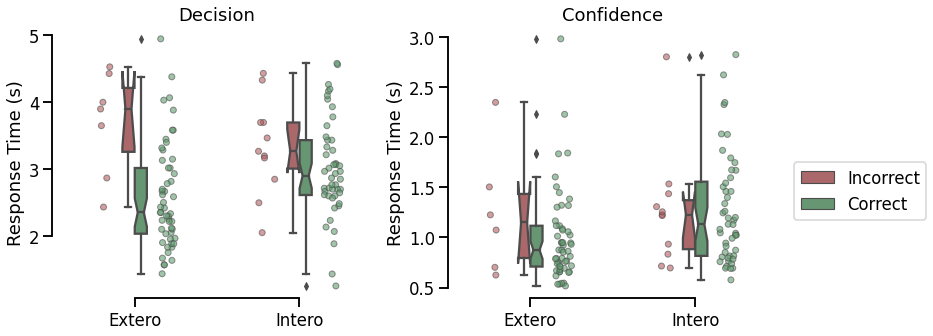

In [6]:
palette = ['#b55d60', '#5f9e6e']

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
for i, task, title in zip([0, 1], ['DecisionRT', 'ConfidenceRT'], ['Decision', 'Confidence']):
    sns.boxplot(data=df, x='Modality', y=task, hue='ResponseCorrect',
                palette=palette, width=.15, notch=True, ax=axs[i])
    sns.stripplot(data=df, x='Modality', y=task, hue='ResponseCorrect',
                  dodge=True, linewidth=1, size=6, palette=palette, alpha=.6, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_ylabel('Response Time (s)')
    axs[i].set_xlabel('')
    axs[i].get_legend().remove()
sns.despine(trim=10)

handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles[0:2], ['Incorrect', 'Correct'], bbox_to_anchor=(1.05, .5), loc=2, borderaxespad=0.)

Response time distribution for the decision and the confidence rating phases for correct (red) and incorrect (green) responses.

# Metacognition

SDT estimate for decision 1 perforamces (d' and criterion)

In [7]:
for i, cond in enumerate(['Intero', 'Extero']):
    this_df = df[df.Modality == cond].copy()
    this_df['Stimuli'] = (this_df.responseBPM > this_df.listenBPM)
    this_df['Responses'] = (this_df.Decision == 'More')

    hit, miss, fa, cr = this_df.scores()
    hr, far = sdt.rates(hits=hit, misses=miss, fas=fa, crs=cr)
    d, c = sdt.dprime(hit_rate=hr, fa_rate=far), sdt.criterion(hit_rate=hr, fa_rate=far)
    
    print(f'Condition: {cond} - d-prime: {d} - criterion: {c}')

Condition: Intero - d-prime: 1.8423907762042766 - criterion: -0.16846659384396856
Condition: Extero - d-prime: 2.393122784867966 - criterion: 0.06558378418882471


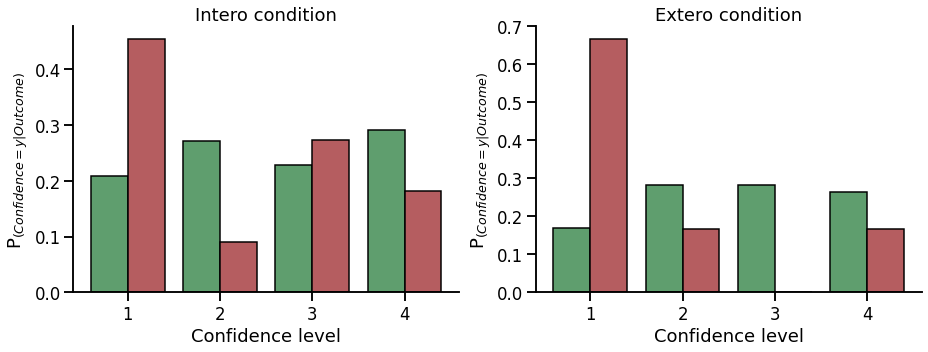

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

for i, cond in enumerate(['Intero', 'Extero']):
    try:
        this_df = df[(df.Modality == cond) & (df.RatingProvided == 1)]
        this_df = this_df[~this_df.Confidence.isnull()]
        new_confidence, _ = discreteRatings(this_df.Confidence)
        this_df['Confidence'] = new_confidence
        this_df['Stimuli'] = (this_df.Alpha > 0).astype('int')
        this_df['Responses'] = (this_df.Decision == 'More').astype('int')
        nR_S1, nR_S2 = trials2counts(data=this_df)
        plot_confidence(nR_S1, nR_S2, ax=axs[i])
        axs[i].set_title(f'{cond} condition')
    except:
        print('Invalid ratings')
        this_df = df[df.Modality == cond]
        sns.histplot(this_df[this_df.ResponseCorrect==1].Confidence, ax=axs[i], color="#5f9e6e",)
        sns.histplot(this_df[this_df.ResponseCorrect==0].Confidence, ax=axs[i], color="#b55d60")
        axs[i].set_title(f'{cond} condition')
sns.despine()
plt.tight_layout()

Distribution of confidence ratings for correct (green) and incorrect (red) trials. Overlapping distribution suggests that the subjective confidence in the decision was not predictive of decision performances.

# Psychophysics

Distribution of the intensities values.

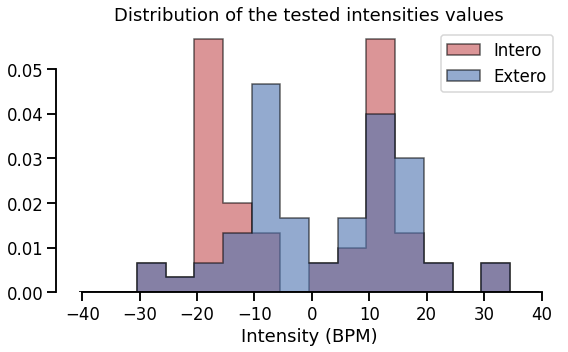

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

for cond, col in zip(['Intero', 'Extero'], ['#c44e52', '#4c72b0']):
    this_df = df[df.Modality == cond]
    axs.hist(this_df.Alpha, color=col, bins=np.arange(-40.5, 40.5, 5), histtype='stepfilled',
             ec="k", density=True, align='mid', label=cond, alpha=.6)
axs.set_title('Distribution of the tested intensities values')
axs.set_xlabel('Intensity (BPM)')
plt.legend()
sns.despine(trim=10)
plt.tight_layout()

## Staircases

### Psi

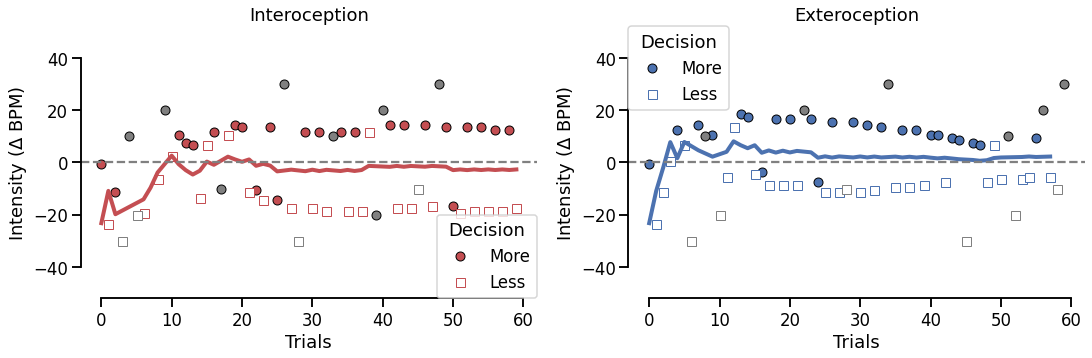

In [10]:
if sum(df.TrialType == 'psi') > 0:

    fig, axs = plt.subplots(figsize=(18, 5), nrows=1, ncols=2)

    # Plot confidence interval for each staircase
    def ci(x):
        return np.where(np.cumsum(x) / np.sum(x) > .025)[0][0], \
               np.where(np.cumsum(x) / np.sum(x) < .975)[0][-1]

    try:
        for i, stair, col in zip([0, 1], [interoPost, exteroPost], ['#c44e52', '#4c72b0']):
            ciUp, ciLow = [], []
            for t in range(stair.shape[0]):
                up, low = ci(stair.mean(2)[t])
                rg = np.arange(-40.5, 40.5) if session == 'Del1' else np.arange(-50.5, 50.5)
                ciUp.append(rg[up])
                ciLow.append(rg[low])
            if session == 'Del1':
                axs[i].fill_between(x=np.arange(len(ciLow)),
                                    y1=ciLow,
                                    y2=ciUp,
                                    color=col, alpha=.2)
            elif session == 'Del2':
                axs[i].fill_between(x=np.linspace(0, len(this_df), len(ciUp)),
                                    y1=ciLow,
                                    y2=ciUp,
                                    color=col, alpha=.2)
    except:
        pass


    # Staircase traces
    for i, cond, col in zip([0, 1], ['Intero', 'Extero'], ['#c44e52', '#4c72b0']):
        this_df = df[(df.Modality == cond) & (df.TrialType != 'UpDown')]

        # Show UpDown staircase traces
        axs[i].plot(np.arange(0, len(this_df))[this_df.StairCond == 'high'], 
                        this_df.Alpha[this_df.StairCond == 'high'], linestyle='--', color=col, linewidth=2)
        axs[i].plot(np.arange(0, len(this_df))[this_df.StairCond == 'low'], 
                        this_df.Alpha[this_df.StairCond == 'low'], linestyle='-', color=col, linewidth=2)
        if session == 'Del1':
            axs[i].plot(np.arange(0, len(this_df))[this_df.Decision == 'More'], 
                            this_df.Alpha[this_df.Decision == 'More'], col, marker='o', linestyle='', markeredgecolor='k', label=cond)
            axs[i].plot(np.arange(0, len(this_df))[this_df.Decision == 'Less'], 
                            this_df.Alpha[this_df.Decision == 'Less'], 'w', marker='s', linestyle='', markeredgecolor=col, label=cond)
        elif session == 'Del2':
            # Use different colors for psi and catch trials
            for trialCond, pointCol in zip(['psi', 'psiCatchTrial'], [col, 'gray']):
                axs[i].plot(np.arange(0, len(this_df))[(this_df.Decision == 'More') & (this_df.TrialType == trialCond)], 
                            this_df.Alpha[(this_df.Decision == 'More') & (this_df.TrialType == trialCond)], 
                            pointCol, marker='o', linestyle='', markeredgecolor='k', label=cond)
                axs[i].plot(np.arange(0, len(this_df))[(this_df.Decision == 'Less') & (this_df.TrialType == trialCond)],
                            this_df.Alpha[(this_df.Decision == 'Less') & (this_df.TrialType == trialCond)], 
                            'w', marker='s', linestyle='', markeredgecolor=pointCol, label=cond)
        
        # Trheshold estimate
        if session == 'Del1':
            axs[i].plot(np.arange(sum(this_df.StairCond != 'psi'), len(this_df)), this_df[this_df.StairCond == 'psi'].EstimatedThreshold, linestyle='-', color=col, linewidth=4)
            axs[i].plot(np.arange(0, sum(this_df.StairCond != 'psi')), this_df[this_df.StairCond != 'psi'].EstimatedThreshold, linestyle='--', color=col, linewidth=2, alpha=.3)
        elif session == 'Del2':
            # Psi trials
            axs[i].plot(np.arange(len(this_df))[this_df.TrialType=='psi'],
                        this_df[this_df.TrialType=='psi'].EstimatedThreshold, linestyle='-', color=col, linewidth=4)
    
        axs[i].axhline(y=0, linestyle='--', color = 'gray')
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles[0:2], ['More', 'Less'], borderaxespad=0., title='Decision')
        axs[i].set_ylabel('Intensity ($\Delta$ BPM)')
        axs[i].set_xlabel('Trials')
        lim = 42 if session=='Del1' else 52
        axs[i].set_ylim(-lim, lim)
        axs[i].set_title(cond+'ception')
        sns.despine(trim=10, ax=axs[i])
        plt.gcf()

This figure represents the evolution of threshold estimate across trials for the Interoception and Exteroception condition. Shaded areas represent the 95% confidence interval of the threshold estimate by Psi. For each condition, the first 30 trials (connected with dashed lines) were allocated to an Up/Down method (2 interleaved staircases starting a -40.5 or 40 respectively). The intensities and responses were included in the Psi staircase to maximize the amount of information included. The remaining 50 trials were monitored by the Psi staircase only. This dual estimation was implemented to estimate the reliability of the estimation of threshold using an up/down procedure, as compared to a longer psi procedure.

# Psychometric function

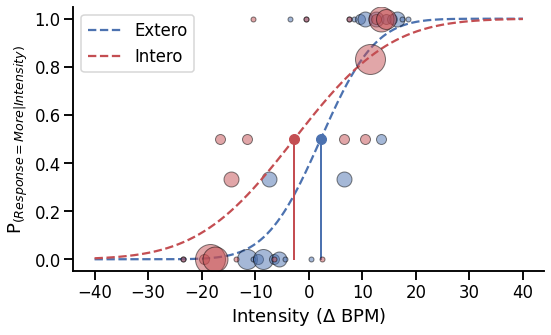

In [11]:
sns.set_context('talk')
fig, axs = plt.subplots(figsize=(8, 5))
for i, modality, col in zip((0, 1), ['Extero', 'Intero'], ['#4c72b0', '#c44e52']):
    
    this_df = df[(df.Modality == modality) & (df.TrialType == 'psi')]

    t, s = this_df.EstimatedThreshold.iloc[-1], this_df.EstimatedSlope.iloc[-1]
    # Plot Psi estimate of psychometric function
    axs.plot(np.linspace(-40, 40, 500), 
            (norm.cdf(np.linspace(-40, 40, 500), loc=t, scale=s)),
            '--', color=col, label=modality)
    # Plot threshold
    axs.plot([t, t], [0, .5], color=col, linewidth=2)
    axs.plot(t, .5, 'o', color=col, markersize=10)

    # Plot data points
    for ii, intensity in enumerate(np.sort(this_df.Alpha.unique())):
        resp = sum((this_df.Alpha == intensity) & (this_df.Decision == 'More'))
        total = sum(this_df.Alpha == intensity)
        axs.plot(intensity, resp/total, 'o', alpha=0.5, color=col, markeredgecolor='k', markersize=total*5)
plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.tight_layout()
plt.legend()
sns.despine()

Psychometric functions fitted using the estimated threshold and slope from the final trial on each condition. The size of the circles reflects the proportion of responses for each intensity level.

# Pulse oximeter

## Visualization of PPG signal

This interactive graph shows the PPG signal recorded at each interoceptive trial. Blue and red time series represent different trials of 6 seconds each. In each trial, the 5 last seconds were used to estimate the average heart rate of the participant, the first second was included to help peak detection algorithm initialization.

Bad trials are represented with shaded area. A trial was marked as bad and removed if one of the two conditions was met:
* Contain a RR interval marked as an outlier. Outliers were detected using the MAD rule on all RR intervals in the recording.
* The standard deviation of the RR interval inside the trial is larger than 5.

In [12]:
drop, bpm_std, bpm_df = [], [], pd.DataFrame([])
clean_df = df.copy()
clean_df['HeartRateOutlier'] = np.zeros(len(clean_df), dtype='bool')
for i, trial in enumerate(signal_df.nTrial.unique()):
    color = '#c44e52' if (i % 2) == 0 else '#4c72b0'
    this_df = signal_df[signal_df.nTrial==trial]  # Downsample to save memory
    
    signal, peaks = oxi_peaks(this_df.signal, sfreq=1000)
    bpm = 60000/np.diff(np.where(peaks)[0])
    
    bpm_df = bpm_df.append(pd.DataFrame({'bpm': bpm, 'nEpoch': i, 'nTrial': trial}))

# Check for outliers in the absolute value of RR intervals 
for e, t in zip(bpm_df.nEpoch[pg.madmedianrule(bpm_df.bpm.to_numpy())].unique(),
                bpm_df.nTrial[pg.madmedianrule(bpm_df.bpm.to_numpy())].unique()):
    drop.append(e)
    clean_df.loc[t, 'HeartRateOutlier'] = True

# Check for outliers in the standard deviation values of RR intervals 
for e, t in zip(np.arange(0, signal_df.nTrial.nunique())[pg.madmedianrule(bpm_df.copy().groupby(['nTrial', 'nEpoch']).bpm.std().to_numpy())],
                signal_df.nTrial.unique()[pg.madmedianrule(bpm_df.copy().groupby(['nTrial', 'nEpoch']).bpm.std().to_numpy())]):
    if e not in drop:
        drop.append(e)
        clean_df.loc[t, 'HeartRateOutlier'] = True

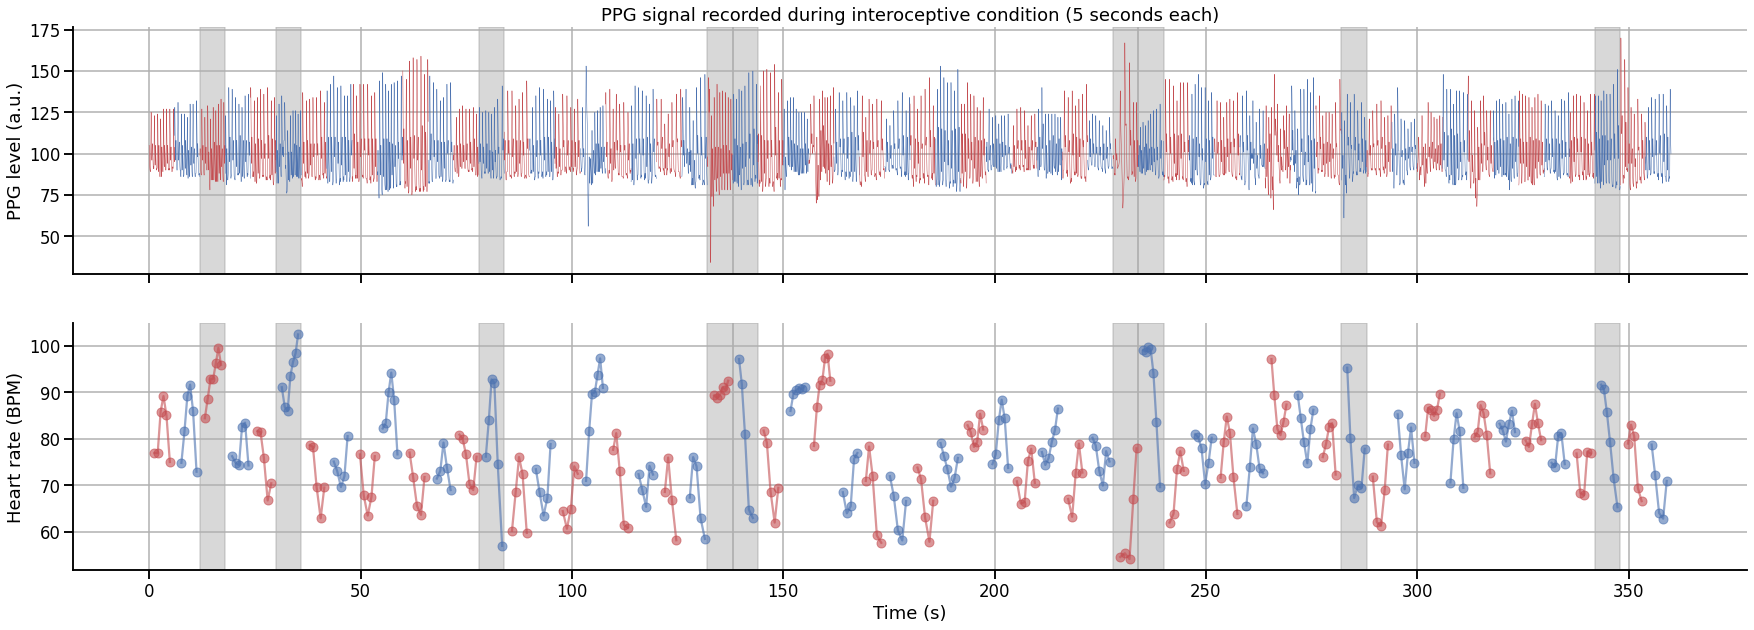

In [13]:
meanBPM, stdBPM, rangeBPM = [], [], []

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(30, 10))
for i, trial in enumerate(signal_df.nTrial.unique()):
    
    color = '#c44e52' if (i % 2) == 0 else '#4c72b0'
    this_df = signal_df[signal_df.nTrial==trial]  # Downsample to save memory
    
    # Mark as outlier if relevant
    if i in drop:
        ax[0].axvspan(this_df.Time.iloc[0], this_df.Time.iloc[-1], alpha=.3, color='gray')
        ax[1].axvspan(this_df.Time.iloc[0], this_df.Time.iloc[-1], alpha=.3, color='gray')
    
    ax[0].plot(this_df.Time, this_df.signal, label='PPG', color=color, linewidth=.5)

    # Peaks detection
    signal, peaks = oxi_peaks(this_df.signal, sfreq=1000)
    bpm = 60000/np.diff(np.where(peaks)[0])
    m, s, r = bpm.mean(), bpm.std(), bpm.max() - bpm.min()
    meanBPM.append(m)
    stdBPM.append(s)
    rangeBPM.append(r)
    
    # Plot instantaneous heart rate
    ax[1].plot(this_df.Time.to_numpy()[np.where(peaks)[0][1:]], 
               60000/np.diff(np.where(peaks)[0]),
              'o-', color=color, alpha=0.6)

ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("PPG level (a.u.)")
ax[1].set_ylabel("Heart rate (BPM)")
ax[0].set_title("PPG signal recorded during interoceptive condition (5 seconds each)")
sns.despine()
ax[0].grid(True)
ax[1].grid(True)

## Heart rate - Summary statistics

This figure show the evolution of the average and standard deviation of the instantaneous heart rate across time. An instantaneous frequnecy was derived between each peak detected in the PPG signal (also known as pulse-to-pulse intervals, or pseudo RR intervals). Rapid increase or decrease of the heart rate frequency can lead to larger standard deviation, and less accurate estimation of the average heart rate.

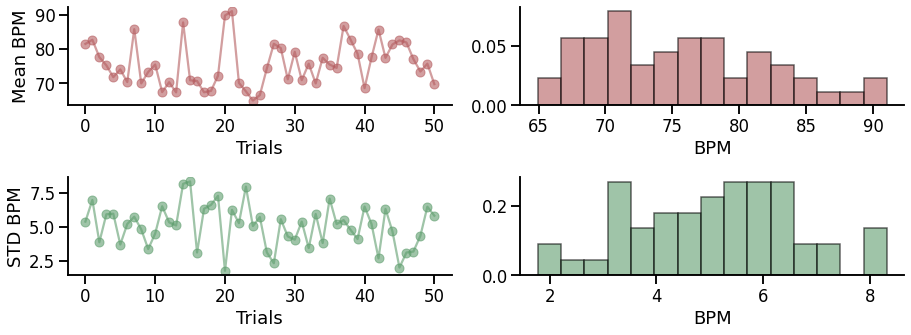

In [14]:
sns.set_context('talk')
fig, axs = plt.subplots(figsize=(13, 5), nrows=2, ncols=2)
meanBPM = np.delete(np.array(meanBPM), np.array(drop))
stdBPM = np.delete(np.array(stdBPM), np.array(drop))
for i, metric, col in zip(range(3), [meanBPM, stdBPM], ['#b55d60', '#5f9e6e']):
    axs[i, 0].plot(metric, 'o-', color=col, alpha=.6)
    axs[i, 1].hist(metric, color=col, bins=15, ec="k", density=True, alpha=.6)
    axs[i, 0].set_ylabel('Mean BPM' if i == 0 else 'STD BPM')
    axs[i, 0].set_xlabel('Trials')
    axs[i, 1].set_xlabel('BPM')
sns.despine()
plt.tight_layout()

# Save dataframe

In [15]:
print(f'{clean_df["HeartRateOutlier"][clean_df.Modality=="Intero"].sum()} Interoception trials and {clean_df["HeartRateOutlier"][clean_df.Modality=="Extero"].sum()} exteroception trials were dropped after trial rejection based on heart rate outliers.')

9 Interoception trials and 0 exteroception trials were dropped after trial rejection based on heart rate outliers.


In [16]:
folder = 'HRD' if session == 'Del1' else 'HRD2'
clean_df.to_csv(os.path.join(outputPath, folder, subject, "filtered.txt"), index=False)